<a href="https://colab.research.google.com/github/JigarJoshi04/Speech_Recognizer/blob/master/Speech_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install typing-extensions==3.7.4.2

ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.
  Found existing installation: typing-extensions 3.6.6
    Uninstalling typing-extensions-3.6.6:
      Successfully uninstalled typing-extensions-3.6.6


In [2]:
!pip install -q https://github.com/pyannote/pyannote-audio/tarball/develop

     | 16.2MB 2.7MB/s
     |████████████████████████████████| 1.6MB 6.4MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 92kB 7.6MB/s 
     |████████████████████████████████| 163kB 39.4MB/s 
     |████████████████████████████████| 1.1MB 33.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 61kB 4.2MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 112kB 45.1MB/s 


In [0]:
!wget -q http://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav


In [0]:
DEMO_FILE = {'uri': 'ES2004a.Mix-Headset', 'audio': 'ES2004a.Mix-Headset.wav'}

In [0]:
!wget -q https://raw.githubusercontent.com/pyannote/pyannote-audio/develop/tutorials/data_preparation/AMI/MixHeadset.test.rttm

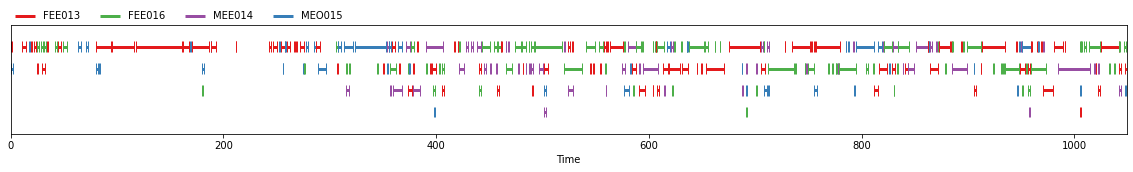

In [6]:
# load groundtruth
from pyannote.database.util import load_rttm
groundtruth = load_rttm('MixHeadset.test.rttm')[DEMO_FILE['uri']]


# visualize groundtruth
groundtruth

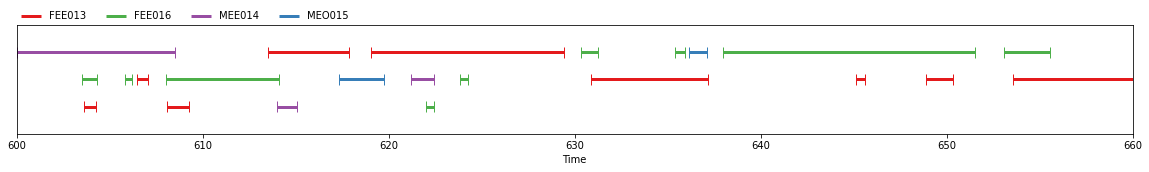

In [7]:
from pyannote.core import Segment, notebook
# make notebook visualization zoom on 600s < t < 660s time range
EXCERPT = Segment(600, 660)
notebook.crop = EXCERPT
  
# visualize excerpt groundtruth
groundtruth

In [20]:
from pyannote.audio.features import RawAudio
from IPython.display import Audio
from scipy.io import wavfile

# load audio waveform, crop excerpt, and play it
waveform = RawAudio(sample_rate=16000).crop(DEMO_FILE, EXCERPT)
Audio(data=waveform.squeeze(), rate=16000, autoplay=True)
demo_new = wavfile.write('result.wav',16000,waveform)
Audio(data=waveform.squeeze,filename ='result.wav',rate=16000,autoplay=True)
print(demo_new)

None


In [0]:
from google.colab import files
files.download('out.txt')

In [0]:
pip install pyannote.database

In [43]:
import torch
scd = torch.hub.load('pyannote/pyannote-audio', 'scd_ami')
# obtain raw SCD scores (as `pyannote.core.SlidingWindowFeature` instance)
new_DEMO_FILE = {'uri': 'ES2004a.Mix-Headset', 'audio': 'result.wav'}
from pyannote.audio.features import Pretrained
# speech activity detection model trained on AMI training set
sad = torch.hub.load('pyannote/pyannote-audio', 'sad_ami')
# speaker change detection model trained on AMI training set
scd = torch.hub.load('pyannote/pyannote-audio', 'scd_ami')
# overlapped speech detection model trained on AMI training set
ovl = torch.hub.load('pyannote/pyannote-audio', 'ovl_ami')
# speaker embedding model trained on AMI training set
emb = torch.hub.load('pyannote/pyannote-audio', 'emb_ami')
# sad = Pretrained(validate_dir='/path/to/validation/directory')
scd_scores = scd(DEMO_FILE)
ovl_scores = ovl(DEMO_FILE)
sad_scores = sad(DEMO_FILE)
from pyannote.audio.utils.signal import Binarize
binarize = Binarize(offset=0.52, onset=0.52, log_scale=True, 
                    min_duration_off=0.1, min_duration_on=0.1)

# speech regions (as `pyannote.core.Timeline` instance)
speech = binarize.apply(sad_scores, dimension=1)
# detect peaks and return speaker homogeneous segments 
# NOTE: both alpha/min_duration values were tuned on AMI dataset.
# you might need to use different values for better results.
from pyannote.audio.utils.signal import Peak
peak = Peak(alpha=0.10, min_duration=0.10, log_scale=True)

# speaker change point (as `pyannote.core.Timeline` instance)
partition = peak.apply(scd_scores, dimension=1)

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master


NameError: ignored

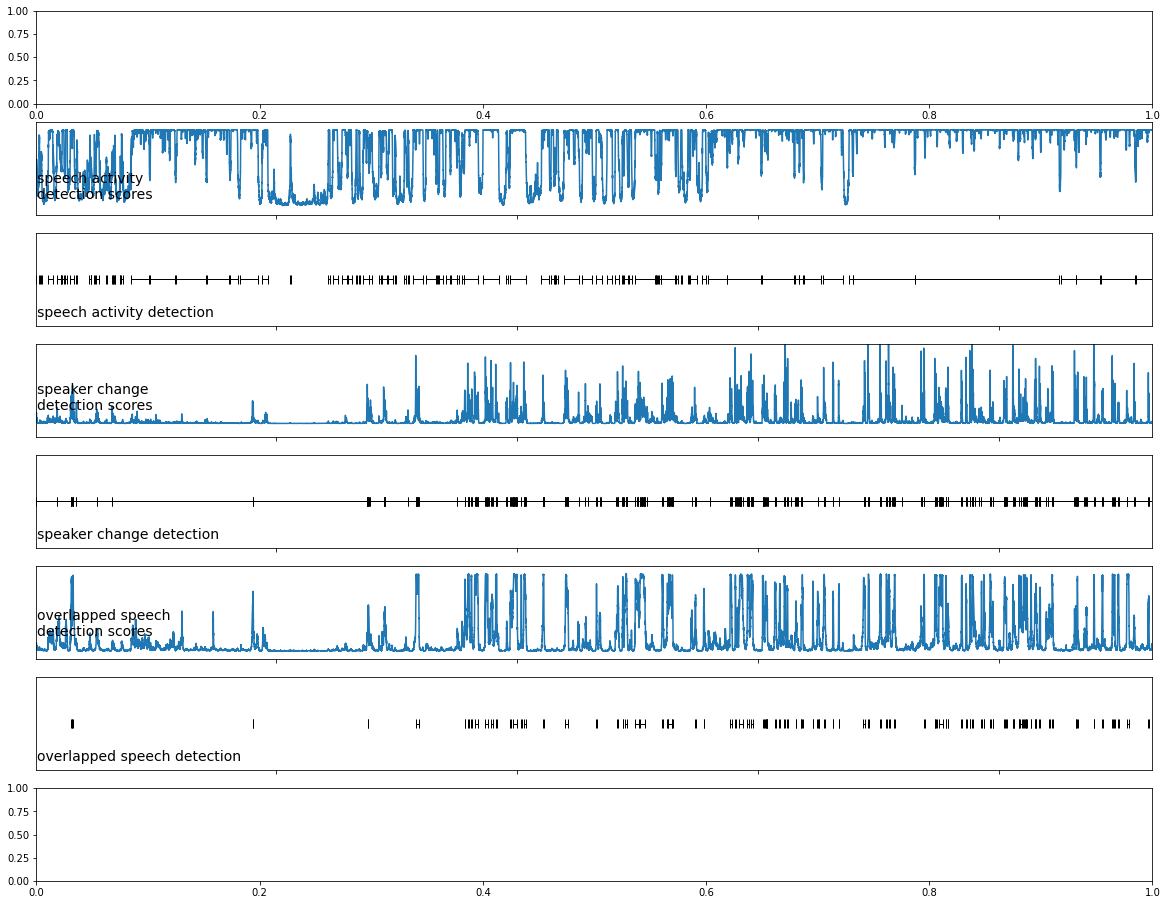

In [51]:
# let's visualize SAD, SCD and OVL results using pyannote.core visualization API
import numpy as np
from matplotlib import pyplot as plt
from pyannote.core import Segment, notebook

# only plot one minute (between t=120s and t=180s)
notebook.crop = Segment(1,927)

# helper function to make visualization prettier
from pyannote.core import SlidingWindowFeature
plot_ready = lambda scores: SlidingWindowFeature(np.exp(scores.data[:, 1:]), scores.sliding_window)

# create a figure with 8 rows with matplotlib
nrows = 8
fig, ax = plt.subplots(nrows=nrows, ncols=1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 2)
overlap = binarize.apply(ovl_scores, dimension=1)
# # 1st row: reference annotation
# notebook.plot_annotation(DEMO_FILE['uri'], ax=ax[0], time=False)
# ax[0].text(notebook.crop.start + 0.5, 0.1, 'reference', fontsize=14)

# 2nd row: SAD raw scores
notebook.plot_feature(plot_ready(sad_scores), ax=ax[1], time=False)
ax[1].text(notebook.crop.start + 0.5, 0.1, 'speech activity\ndetection scores', fontsize=14)
ax[1].set_ylim(-0.1, 1.1)

# 3rd row: SAD result
notebook.plot_timeline(speech, ax=ax[2], time=False)
ax[2].text(notebook.crop.start + 0.5, 0.1, 'speech activity detection', fontsize=14)

# 4th row: SCD raw scores
notebook.plot_feature(plot_ready(scd_scores), ax=ax[3], time=False)
ax[3].text(notebook.crop.start + 0.5, 0.1, 'speaker change\ndetection scores', fontsize=14)
ax[3].set_ylim(-0.1, 0.6)

# 5th row: SCD result
notebook.plot_timeline(partition, ax=ax[4], time=False)
ax[4].text(notebook.crop.start + 0.5, 0.1, 'speaker change detection', fontsize=14)

# 6th row: OVL raw scores
notebook.plot_feature(plot_ready(ovl_scores), ax=ax[5], time=False)
ax[5].text(notebook.crop.start + 0.5, 0.2, 'overlapped speech\ndetection scores', fontsize=14)
ax[5].set_ylim(-0.1, 1.1)

# 7th row: OVL result
notebook.plot_timeline(overlap, ax=ax[6], time=False)
ax[6].text(notebook.crop.start + 0.5, 0.1, 'overlapped speech detection', fontsize=14)

# 8th row: reference annotation
notebook.plot_annotation(test_file['annotation'], ax=ax[7], legend=False)
_ = ax[7].text(notebook.crop.start + 0.5, 0.1, 'reference', fontsize=14)

Text(600.5, 0.1, 'speaker change detection')

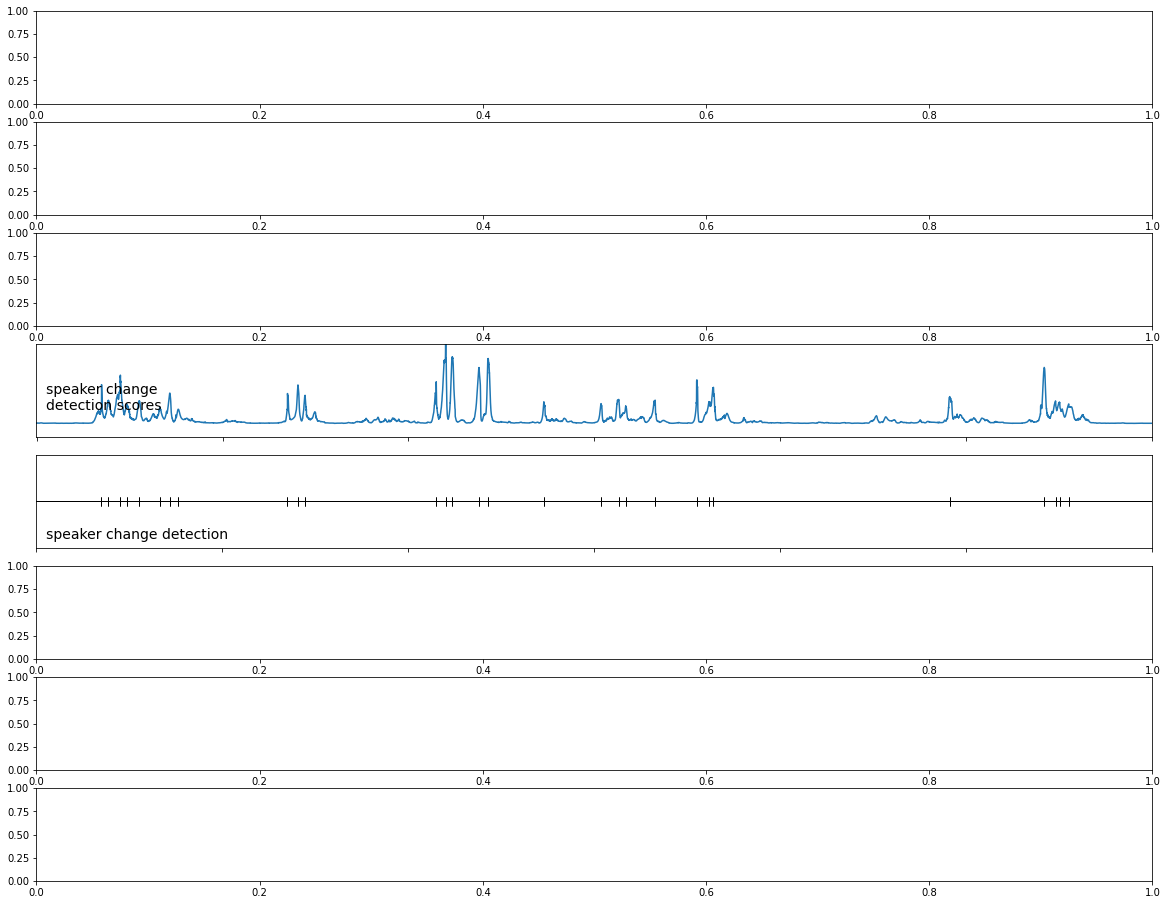

In [28]:
# let's visualize SAD, SCD and OVL results using pyannote.core visualization API
import numpy as np
from matplotlib import pyplot as plt
from pyannote.core import Segment, notebook

# only plot one minute (between t=120s and t=180s)
notebook.crop = Segment(600, 660)

# helper function to make visualization prettier
from pyannote.core import SlidingWindowFeature
plot_ready = lambda scores: SlidingWindowFeature(np.exp(scores.data[:, 1:]), scores.sliding_window)

# create a figure with 8 rows with matplotlib
nrows = 8
fig, ax = plt.subplots(nrows=nrows, ncols=1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 2)




# 4th row: SCD raw scores
notebook.plot_feature(plot_ready(scd_scores), ax=ax[3], time=False)
ax[3].text(notebook.crop.start + 0.5, 0.1, 'speaker change\ndetection scores', fontsize=14)
ax[3].set_ylim(-0.1, 0.6)

# 5th row: SCD result
notebook.plot_timeline(partition, ax=ax[4], time=False)
ax[4].text(notebook.crop.start + 0.5, 0.1, 'speaker change detection', fontsize=14)

In [24]:
# load pipeline
import torch

pipeline = torch.hub.load('pyannote/pyannote-audio', 'dia')

# apply diarization pipeline on your audio file
# diarization = pipeline({'audio': '/content/ES2004a.Mix-Headset.wav.1'})
diarization = pipeline({'audio': '/content/ES2004a.Mix-Headset.wav'})

fe= open("out.txt","w")
fe.write("We start")
# dump result to disk using RTTM format
with open('result.wav', 'w') as f:
    diarization.write_rttm(f)
  
# iterate over speech turns
for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f'Speaker "{speaker}" speaks between t={turn.start:.1f}s and t={turn.end:.1f}s.')
    fe.write(f'Speaker "{speaker}" speaks between t={turn.start:.1f}s and t={turn.end:.1f}s.')
    fe.write(" \n ")
# Speaker "A" speaks between t=0.2s and t=1.4s.
# Speaker "B" speaks between t=2.3s and t=4.8s.
# Speaker "A" speaks between t=5.2s and t=8.3s.
# Speaker "C" speaks between t=8.3s and t=9.4s.


Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master
/usr/local/lib/python3.6/dist-packages/pyannote/audio/features/pretrained.py:153: UserWarning:

Model was trained with 4s chunks and is applied on 2s chunks. This might lead to sub-optimal results.

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master


Speaker "A" speaks between t=10.9s and t=14.7s.
Speaker "B" speaks between t=17.5s and t=18.2s.
Speaker "B" speaks between t=18.5s and t=19.4s.
Speaker "B" speaks between t=19.7s and t=20.2s.
Speaker "B" speaks between t=20.6s and t=20.7s.
Speaker "A" speaks between t=22.4s and t=24.4s.
Speaker "A" speaks between t=25.1s and t=25.2s.
Speaker "B" speaks between t=25.2s and t=26.5s.
Speaker "B" speaks between t=27.8s and t=30.5s.
Speaker "A" speaks between t=30.8s and t=32.0s.
Speaker "B" speaks between t=34.2s and t=35.1s.
Speaker "B" speaks between t=37.1s and t=37.4s.
Speaker "B" speaks between t=40.0s and t=40.6s.
Speaker "B" speaks between t=41.0s and t=42.2s.
Speaker "B" speaks between t=42.6s and t=43.5s.
Speaker "B" speaks between t=44.8s and t=46.0s.
Speaker "C" speaks between t=46.3s and t=47.2s.
Speaker "B" speaks between t=47.2s and t=48.0s.
Speaker "B" speaks between t=50.6s and t=50.7s.
Speaker "B" speaks between t=51.0s and t=51.7s.
Speaker "B" speaks between t=52.2s and t